Device: cpu


/home/codespace/.local/lib/python3.12/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/codespace/.local/lib/python3.12/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([21, 1, 1])) that is different to the input size (torch.Size([21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/codespace/.local/lib/python3.12/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensu

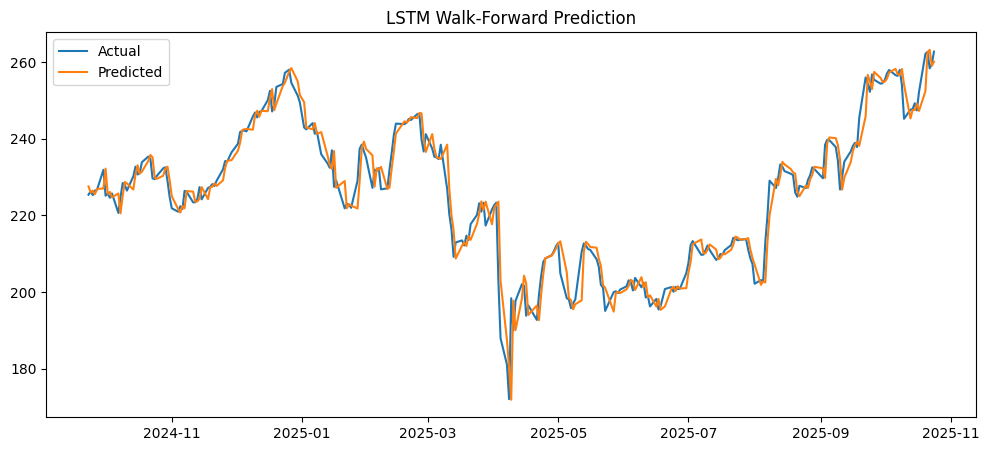

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---------------------------------------
# 1) Load your data
# ---------------------------------------

filepath = "/workspaces/Independent_study_Time_series_analysis/AAPL_two_years.xlsx"
df = pd.read_excel(filepath)

df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")

# we need Close price
df = df[["Close"]].copy()

# ---------------------------------------
# 2) Create log-returns (stationary target)
# ---------------------------------------

df["log_close"] = np.log(df["Close"])
df["log_return"] = df["log_close"].diff()
df = df.dropna()

# ---------------------------------------
# 3) Feature Engineering
# ---------------------------------------

df["ret_lag1"] = df["log_return"].shift(1)
df["ret_lag2"] = df["log_return"].shift(2)
df["rolling_mean_5"] = df["log_return"].rolling(5).mean()
df["rolling_std_10"] = df["log_return"].rolling(10).std()
df = df.dropna()

FEATURE_COLS = ["ret_lag1", "ret_lag2", "rolling_mean_5", "rolling_std_10"]
TARGET_COL = "log_return"
LOOKBACK = 20

# ---------------------------------------
# 4) Dataset for PyTorch
# ---------------------------------------

class SeqDataset(Dataset):
    def __init__(self, X, y, lookback):
        self.X = []
        self.y = []
        for i in range(len(X) - lookback):
            self.X.append(X[i:i+lookback])
            self.y.append(y[i+lookback])
        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        self.y = torch.tensor(np.array(self.y), dtype=torch.float32).unsqueeze(-1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ---------------------------------------
# 5) LSTM model
# ---------------------------------------

class LSTMModel(nn.Module):
    def __init__(self, n_features, hidden_size=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        o, _ = self.lstm(x)
        last = o[:, -1, :]
        return self.fc(last)

# ---------------------------------------
# 6) Walk-forward training + prediction
# ---------------------------------------

def walk_forward(df):
    preds = []
    actual = []
    dates = []

    initial_train = 200  # first 200 points used for training
    n = len(df)

    for t in range(initial_train, n - 1):

        train_df = df.iloc[:t+1]

        Xtrain = train_df[FEATURE_COLS].values
        ytrain = train_df[TARGET_COL].values.reshape(-1,1)

        scalerX = StandardScaler().fit(Xtrain)
        scalery = StandardScaler().fit(ytrain)

        Xs = scalerX.transform(Xtrain)
        ys = scalery.transform(ytrain)

        dataset = SeqDataset(Xs, ys, LOOKBACK)
        if len(dataset) < 5:
            continue

        loader = DataLoader(dataset, batch_size=32, shuffle=False)

        model = LSTMModel(n_features=len(FEATURE_COLS)).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        loss_fn = nn.MSELoss()

        model.train()
        for epoch in range(2):  # increase to 10 for better accuracy
            for Xb, yb in loader:
                Xb = Xb.to(device)
                yb = yb.to(device)

                optimizer.zero_grad()
                yp = model(Xb)
                loss = loss_fn(yp, yb)
                loss.backward()
                optimizer.step()

        last_seq = df[FEATURE_COLS].iloc[t-LOOKBACK+1:t+1].values
        last_seq = scalerX.transform(last_seq).reshape(1, LOOKBACK, -1)
        last_seq = torch.tensor(last_seq, dtype=torch.float32).to(device)

        model.eval()
        with torch.no_grad():
            p_scaled = model(last_seq).cpu().numpy()[0][0]

        pred_return = scalery.inverse_transform([[p_scaled]])[0][0]

        last_price = df["Close"].iloc[t]
        pred_price = last_price * math.exp(pred_return)
        true_price = df["Close"].iloc[t+1]

        preds.append(pred_price)
        actual.append(true_price)
        dates.append(df.index[t+1])

    return np.array(preds), np.array(actual), dates

# ---------------------------------------
# 7) Run walk-forward
# ---------------------------------------

pred, real, dates = walk_forward(df)

plt.figure(figsize=(12,5))
plt.plot(dates, real, label="Actual")
plt.plot(dates, pred, label="Predicted")
plt.legend()
plt.title("LSTM Walk-Forward Prediction")
plt.show()
